In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
# from model_mnist import CNN
from classifier_model import Model_A,Model_B,Model_C,Model_D,Model_E,Model_F
import torchvision
import numpy as np

import torch.optim as optim

from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler
import os

from torchsummary import summary
import copy

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
total_epoch = 100
batch_size = 128
# LR = 1E-3

In [6]:
transform_train = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
#     transforms.Pad(padding=2),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

### MNIST

In [5]:
trainset = datasets.MNIST(
    root='./data', train=True, download=True, transform=transform_train)

train_indices, val_indices = train_test_split(np.arange(len(trainset)), test_size=0.2)

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

trainloader = DataLoader(
    trainset,
    batch_size=batch_size,
    num_workers=2,
    sampler=train_sampler
)

val_loader = DataLoader(
    trainset,
    batch_size=batch_size,
    num_workers=2,
    sampler=valid_sampler
)

testset = datasets.MNIST(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
train_size = len(train_sampler)
val_size = len(valid_sampler)

In [ ]:
print('length trainset : {}, testset : {}'.format(len(trainset), len(testset)))

In [ ]:
classes = ('zero', 'one', 'two', 'three', 'four', 
           'five', 'six', 'seven', 'eight', 'nine')

### F-MNIST

In [7]:
trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_train)

train_indices, val_indices = train_test_split(np.arange(len(trainset)), test_size=0.2)

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

trainloader = DataLoader(
    trainset,
    batch_size=batch_size,
    num_workers=2,
    sampler=train_sampler
)

val_loader = DataLoader(
    trainset,
    batch_size=batch_size,
    num_workers=2,
    sampler=valid_sampler
)

testset = datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [8]:
train_size = len(train_sampler)
val_size = len(valid_sampler)

In [9]:
print('length trainset : {}, testset : {}'.format(len(trainset), len(testset)))

length trainset : 60000, testset : 10000


In [10]:
classes = ('t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot')

### show images

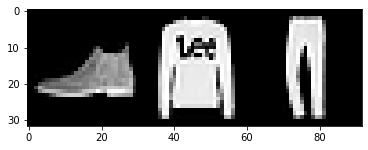

ankle boot   pullover    trouser


In [11]:
import matplotlib.pyplot as plt

# functions to show an image

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(testloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:3]))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(3)))

### Train

In [21]:
# model = CNN()
model = Model_A()

In [22]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [24]:
summary(model, input_size = (1,28,28), device = 'cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]           1,664
              ReLU-2           [-1, 64, 28, 28]               0
            Conv2d-3           [-1, 64, 12, 12]         102,464
              ReLU-4           [-1, 64, 12, 12]               0
           Dropout-5           [-1, 64, 12, 12]               0
            Linear-6                  [-1, 128]       1,179,776
              ReLU-7                  [-1, 128]               0
           Dropout-8                  [-1, 128]               0
            Linear-9                   [-1, 10]           1,290
          Softmax-10                   [-1, 10]               0
Total params: 1,285,194
Trainable params: 1,285,194
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.98
Params size (MB): 4.90
Estimat

In [25]:
model = model.to(device)

In [55]:
# model.load_state_dict(torch.load('./checkpoints/F_mnist_model_D.pth'))

<All keys matched successfully>

In [26]:
model_folder = os.path.abspath('./checkpoints')
if not os.path.exists(model_folder):
    os.mkdir(model_folder)
# model_path = os.path.join(model_folder, 'mnist_model_D.pth')
# model_path = os.path.join(model_folder, 'F_mnist_model_A.pth')

In [27]:
import torchattacks

In [28]:
test_epoch =[10,30,50,70,90]

In [29]:
model.train()  # Set model to training mode

train_loss = []
train_acc = []
val_loss = []
val_acc = []

best_acc = 0.0

for epoch in range(total_epoch):
    
    model.train()# Set model to training mode
    
    running_loss = 0.0
    running_corrects = 0.0
    epoch_size = 0.0
    
    for batch_idx, (inputs, labels) in enumerate(trainloader):
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
#         print(outputs.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        
        _, preds = torch.max(outputs, 1)

        optimizer.step()

        # print statistics
        # statistics
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        
        epoch_size += inputs.size(0)
        
    # Normalizing the loss by the total number of train batches
    
    running_loss /= epoch_size
    running_corrects =  running_corrects.double() / epoch_size
    
    train_loss.append(running_loss)
    train_acc.append(running_corrects)
    
    print('train Loss: {:.4f} Acc: {:.4f}'.format(running_loss, running_corrects))
    
    # evalute
    print('Finished epoch {}, starting evaluation'.format(epoch+1))

    model.eval()   # Set model to evaluate mode
    
    running_loss = 0.0
    running_corrects = 0.0
    epoch_size = 0.0
    
    
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(val_loader):
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

            # statistics
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data)
            
            epoch_size += inputs.size(0)
    
    running_loss /= epoch_size
    running_corrects =  running_corrects.double() / epoch_size
    
    print('Validation Loss: {:.4f} Acc: {:.4f}'.format(running_loss, running_corrects))
    
    val_loss.append(running_loss)
    val_acc.append(running_corrects)
    
    # deep copy the model
#     if running_corrects > best_acc:
#         print("saving best model val_acc : {:.4f}".format(running_corrects))
#         best_acc = running_corrects
        
#         model_copy = copy.deepcopy(model)
#         model_copy = model_copy.cpu()
        
#         model_state_dict = model_copy.state_dict()
#         torch.save(model_state_dict, model_path)

#         del model_copy
    
    running_corrects = 0.0
    epoch_size = 0.0
    
    if (epoch+1) in test_epoch:
        attack = torchattacks.FGSM(model, eps=0.3)
        for batch_idx, (inputs, labels) in enumerate(testloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            adv_image = attack(inputs, labels)
            
            outputs = model(adv_image)
            _, preds = torch.max(outputs, 1)

            # statistics
            running_corrects += torch.sum(preds == labels.data)
            
            epoch_size += inputs.size(0)
    
        running_corrects =  running_corrects.double() / epoch_size
        print('EPOCH {} FGSM Acc: {:.4f}'.format(epoch+1, running_corrects))

print('==> Finished Training ...')

train Loss: 0.0135 Acc: 0.7389
Finished epoch 1, starting evaluation
Validation Loss: 0.0130 Acc: 0.8045
train Loss: 0.0130 Acc: 0.8013
Finished epoch 2, starting evaluation
Validation Loss: 0.0129 Acc: 0.8183
train Loss: 0.0129 Acc: 0.8109
Finished epoch 3, starting evaluation
Validation Loss: 0.0128 Acc: 0.8302
train Loss: 0.0128 Acc: 0.8201
Finished epoch 4, starting evaluation
Validation Loss: 0.0127 Acc: 0.8336
train Loss: 0.0128 Acc: 0.8256
Finished epoch 5, starting evaluation
Validation Loss: 0.0127 Acc: 0.8357
train Loss: 0.0126 Acc: 0.8515
Finished epoch 6, starting evaluation
Validation Loss: 0.0124 Acc: 0.8766
train Loss: 0.0125 Acc: 0.8666
Finished epoch 7, starting evaluation
Validation Loss: 0.0124 Acc: 0.8823
train Loss: 0.0124 Acc: 0.8741
Finished epoch 8, starting evaluation
Validation Loss: 0.0124 Acc: 0.8832
train Loss: 0.0123 Acc: 0.8825
Finished epoch 9, starting evaluation
Validation Loss: 0.0123 Acc: 0.8896
train Loss: 0.0123 Acc: 0.8862
Finished epoch 10, start

Validation Loss: 0.0121 Acc: 0.9145
train Loss: 0.0119 Acc: 0.9344
Finished epoch 78, starting evaluation
Validation Loss: 0.0121 Acc: 0.9137
train Loss: 0.0119 Acc: 0.9323
Finished epoch 79, starting evaluation
Validation Loss: 0.0121 Acc: 0.9112
train Loss: 0.0119 Acc: 0.9337
Finished epoch 80, starting evaluation
Validation Loss: 0.0121 Acc: 0.9143
train Loss: 0.0119 Acc: 0.9337
Finished epoch 81, starting evaluation
Validation Loss: 0.0121 Acc: 0.9164
train Loss: 0.0120 Acc: 0.9309
Finished epoch 82, starting evaluation
Validation Loss: 0.0121 Acc: 0.9152
train Loss: 0.0120 Acc: 0.9313
Finished epoch 83, starting evaluation
Validation Loss: 0.0121 Acc: 0.9129
train Loss: 0.0119 Acc: 0.9333
Finished epoch 84, starting evaluation
Validation Loss: 0.0121 Acc: 0.9140
train Loss: 0.0119 Acc: 0.9329
Finished epoch 85, starting evaluation
Validation Loss: 0.0121 Acc: 0.9150
train Loss: 0.0119 Acc: 0.9330
Finished epoch 86, starting evaluation
Validation Loss: 0.0122 Acc: 0.9087
train Loss

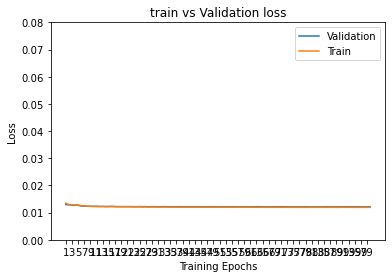

In [30]:
hist = [h for h in val_loss]
hist2 = [h for h in train_loss]

plt.title("train vs Validation loss")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(range(1,len(val_loss)+1),hist,label="Validation")
plt.plot(range(1,len(train_loss)+1),hist2,label="Train")
plt.ylim((0,0.08))
plt.xticks(np.arange(1, len(train_loss)+1, 2))
plt.legend()
plt.show()

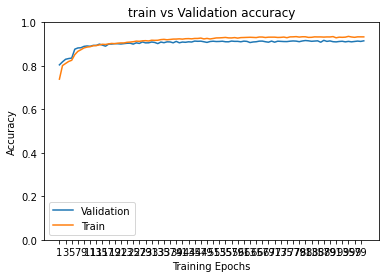

In [31]:
hist = [h.cpu() for h in val_acc]
hist2 = [h.cpu() for h in train_acc]

plt.title("train vs Validation accuracy")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1,len(val_acc)+1),hist,label="Validation")
plt.plot(range(1,len(train_acc)+1),hist2,label="Train")
plt.ylim((0,1.0))
plt.xticks(np.arange(1, len(train_acc)+1, 2))
plt.legend()
plt.show()